# Introduction

This notebook builds some models on the Rossmann dataset

# Setup

Navigate to the project's root directory:

In [1]:
%cd ..

/tmp/temp_project


# Libraries

In [2]:
import src.custom_transform as custom_transform

In [3]:
from fastai.tabular import *

In [4]:
from pathlib import Path
import pandas as pd

# Utilities

Function to make a submission file:

In [5]:
def create_submission_filename(learner, file_name):
    test_preds = learn.get_preds(DatasetType.Test)
    test_df["Sales"] = np.exp(test_preds[0].data).numpy().T[0]
    test_df[["Id","Sales"]] = test_df[["Id","Sales"]].astype("int")
    test_df[["Id","Sales"]].to_csv(file_name,index=False)

# Data

Load the training and test set:

In [6]:
DATA_DIR = Path('../data')

In [7]:
train_df = pd.read_parquet(DATA_DIR/'train_clean.parquet')
test_df = pd.read_parquet(DATA_DIR/'test_clean.parquet')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Define the continuous and categorical variables:

In [8]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday', 'CloudCover']


cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

Define the dependent variable:

In [9]:
dep_var = 'Sales'

Define the validation set:

In [10]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

# Modelling

## Standard

Define the preprocessing steps we want to do:

In [11]:
procs=[FillMissing, Categorify, Normalize]

Define the databunch we will use for modelling:

In [12]:
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

print(f'Number of categorical variables: {len(cat_vars)}')
print(f'Number of continuous variables: {len(cont_vars)}')
df.shape

Number of categorical variables: 25
Number of continuous variables: 13


(844338, 40)

In [13]:
data = (TabularList.from_df(df, path=DATA_DIR, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=DATA_DIR, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

Define the model:

In [14]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [15]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

View the model's architecture:

In [16]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(10, 6)
    (25): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=239, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, mome

Do the training:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


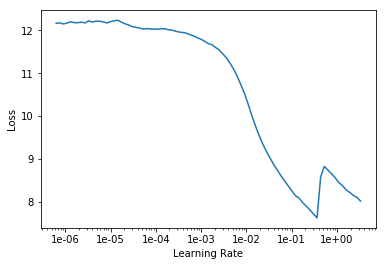

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
%%time
for i in range(3):
    learn.fit_one_cycle(5, 1e-3, wd=0.2)
    create_submission_filename(learn, f'submission_standard_stage_{i+1}.csv')

CPU times: user 46min 55s, sys: 2min 13s, total: 49min 8s
Wall time: 43min 33s


In [19]:
# %%time
# learn.fit_one_cycle(5, 1e-3, wd=0.2)

# With quantile normalization and powers

Reset the variables we will use:

In [15]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw', 'Promo', 'SchoolHoliday', 'CloudCover']


cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday']

We will do the preprocessing ourselves:

In [16]:
procs = []

categorify_proc = Categorify(cat_names=list(cat_vars), cont_names=list(cont_vars))
quantile_proc = custom_transform.QuantileNormalize(cat_names=list(cat_vars), cont_names=list(cont_vars))
power_proc = custom_transform.Power(cat_names=list(cat_vars), cont_names=list(cont_vars))
fill_missing_proc = FillMissing(cat_names=list(cat_vars), cont_names=list(cont_vars))

tmp_valid_df = train_df.iloc[list(valid_idx)].copy()
tmp_train_df = train_df.iloc[(valid_idx[-1] + 1):].copy()
assert tmp_valid_df.shape[0] + tmp_train_df.shape[0] == train_df.shape[0]

fill_missing_proc.apply_train(tmp_train_df)
categorify_proc.apply_train(tmp_train_df)
quantile_proc.apply_train(tmp_train_df)
power_proc.apply_train(tmp_train_df)

fill_missing_proc.apply_test(tmp_valid_df)
categorify_proc.apply_test(tmp_valid_df)
quantile_proc.apply_test(tmp_valid_df)
power_proc.apply_test(tmp_valid_df)

fill_missing_proc.apply_test(test_df)
categorify_proc.apply_test(test_df)
quantile_proc.apply_test(test_df)
power_proc.apply_test(test_df)

# put everything back together
new_cont_vars = itertools.chain(*[[var, var + '_square', var + '_sqrt']
                                  for var in cont_vars])
new_cont_vars = list(new_cont_vars)

new_cat_vars = cat_vars + ['CompetitionDistance_na']

train_df = pd.concat([tmp_valid_df, tmp_train_df], axis=0)

df = train_df[new_cat_vars + new_cont_vars + [dep_var, 'Date']].copy()

data = (TabularList.from_df(df, path=DATA_DIR, cat_names=cat_vars, cont_names=cont_vars, procs=procs, )
        .split_by_idx(valid_idx)
        .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
        .add_test(TabularList.from_df(test_df, path=DATA_DIR, cat_names=cat_vars, cont_names=cont_vars))
        .databunch())

print(f'Number of categorical variables: {len(new_cat_vars)}')
print(f'Number of continuous variables: {len(new_cont_vars)}')
df.shape

Number of categorical variables: 26
Number of continuous variables: 39


(844338, 67)

Define the model:

In [17]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [18]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

View model's architecture:

In [19]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(10, 6)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=236, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, tra

Do the training:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


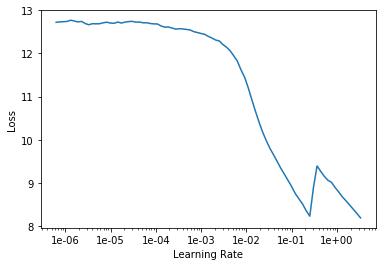

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
%%time
for i in range(3):
    learn.fit_one_cycle(5, 1e-3, wd=0.2)
    create_submission_filename(learn, f'submission_custom_stage_{i+1}.csv')

CPU times: user 45min 48s, sys: 2min 17s, total: 48min 5s
Wall time: 42min 34s


In [27]:
# %%time
# learn.fit_one_cycle(10, 1e-3, wd=0.2)